In [ ]:
from config import *
from CRFmodel import CRFModel

speaker_vocab_dict_path = 'vocabs/speaker_vocab.pkl'
emotion_vocab_dict_path = 'vocabs/emotion_vocab.pkl'
sentiment_vocab_dict_path = 'vocabs/sentiment_vocab.pkl'


def pad_to_len(list_data, max_len, pad_value):
    list_data = list_data[-max_len:]
    len_to_pad = max_len-len(list_data)
    pads = [pad_value] * len_to_pad
    list_data.extend(pads)
    return list_data


def get_vocabs(file_paths, addi_file_path):
    speaker_vocab = vocab.UnkVocab()
    emotion_vocab = vocab.Vocab()
    sentiment_vocab = vocab.Vocab()
    # 保证neutral 在第0类
    emotion_vocab.word2index('neutral', train=True)
    # global speaker_vocab, emotion_vocab
    for file_path in file_paths:
        data = pd.read_csv(file_path)
        for row in tqdm(data.iterrows(), desc='get vocab from {}'.format(file_path)):
            meta = row[1]
            emotion = meta['Emotion'].lower()
            emotion_vocab.word2index(emotion, train=True)
    additional_data = json.load(open(addi_file_path, 'r'))
    for episode_id in additional_data:
        for scene in additional_data.get(episode_id):
            for utterance in scene['utterances']:
                speaker = utterance['speakers'][0].lower()
                speaker_vocab.word2index(speaker, train=True)
    speaker_vocab = speaker_vocab.prune_by_count(1000)
    speakers = list(speaker_vocab.counts.keys())
    speaker_vocab = vocab.UnkVocab()
    for speaker in speakers:
        speaker_vocab.word2index(speaker, train=True)

    logging.info('total {} speakers'.format(len(speaker_vocab.counts.keys())))
    torch.save(emotion_vocab.to_dict(), emotion_vocab_dict_path)
    torch.save(speaker_vocab.to_dict(), speaker_vocab_dict_path)
    torch.save(sentiment_vocab.to_dict(), sentiment_vocab_dict_path)

def load_emorynlp_and_builddataset(file_path, train=False):
    speaker_vocab = vocab.UnkVocab.from_dict(torch.load(
        speaker_vocab_dict_path
    ))
    emotion_vocab = vocab.Vocab.from_dict(torch.load(
        emotion_vocab_dict_path
    ))
    data = pd.read_csv(file_path)
    ret_utterances = []
    ret_speaker_ids = []
    ret_emotion_idxs = []
    utterances = []
    full_contexts = []
    speaker_ids = []
    emotion_idxs = []
    sentiment_idxs = []
    pre_dial_id = -1
    max_turns = 0
    for row in tqdm(data.iterrows(), desc='processing file {}'.format(file_path)):
        meta = row[1]
        utterance = meta['Utterance'].lower().replace(
            '’', '\'').replace("\"", '')
        speaker = meta['Speaker'].lower()
        utterance = speaker + ' says:, ' + utterance
        emotion = meta['Emotion'].lower()
        dialogue_id = meta['Scene_ID']
        utterance_id = meta['Utterance_ID']
        if pre_dial_id == -1:
            pre_dial_id = dialogue_id
        if dialogue_id != pre_dial_id:
            ret_utterances.append(full_contexts)
            ret_speaker_ids.append(speaker_ids)
            ret_emotion_idxs.append(emotion_idxs)
            max_turns = max(max_turns, len(utterances))
            utterances = []
            full_contexts = []
            speaker_ids = []
            emotion_idxs = []
        pre_dial_id = dialogue_id
        speaker_id = speaker_vocab.word2index(speaker)
        emotion_idx = emotion_vocab.word2index(emotion)
        token_ids = tokenizer(utterance, add_special_tokens=False)[
            'input_ids'] + [CONFIG['SEP']]
        full_context = []
        if len(utterances) > 0:
            context = utterances[-3:]
            for pre_uttr in context:
                full_context += pre_uttr
        full_context += token_ids
        # query
        query = speaker + ' feels <mask>'
        query_ids = [CONFIG['SEP']] + tokenizer(query, add_special_tokens=False)['input_ids'] + [CONFIG['SEP']]
        full_context += query_ids

        full_context = pad_to_len(
            full_context, CONFIG['max_len'], CONFIG['pad_value'])
        # + CONFIG['shift']
        utterances.append(token_ids)
        full_contexts.append(full_context)
        speaker_ids.append(speaker_id)
        emotion_idxs.append(emotion_idx)

    pad_utterance = [CONFIG['SEP']] + tokenizer(
        "1",
        add_special_tokens=False
    )['input_ids'] + [CONFIG['SEP']]
    pad_utterance = pad_to_len(
        pad_utterance, CONFIG['max_len'], CONFIG['pad_value'])
    # for CRF
    ret_mask = []
    ret_last_turns = []
    for dial_id, utterances in tqdm(enumerate(ret_utterances), desc='build dataset'):
        mask = [1] * len(utterances)
        while len(utterances) < max_turns:
            utterances.append(pad_utterance)
            ret_emotion_idxs[dial_id].append(-1)
            ret_speaker_ids[dial_id].append(0)
            mask.append(0)
        ret_mask.append(mask)
        ret_utterances[dial_id] = utterances

        last_turns = [-1] * max_turns
        for turn_id in range(max_turns):
            curr_spk = ret_speaker_ids[dial_id][turn_id]
            if curr_spk == 0:
                break
            for idx in range(0, turn_id):
                if curr_spk == ret_speaker_ids[dial_id][idx]:
                    last_turns[turn_id] = idx
        ret_last_turns.append(last_turns)
    dataset = TensorDataset(
        torch.LongTensor(ret_utterances),
        torch.LongTensor(ret_speaker_ids),
        torch.LongTensor(ret_emotion_idxs),
        torch.ByteTensor(ret_mask),
        torch.LongTensor(ret_last_turns)
    )
    return dataset


def load_meld_and_builddataset(file_path, train=False):
    speaker_vocab = vocab.UnkVocab.from_dict(torch.load(
        speaker_vocab_dict_path
    ))
    emotion_vocab = vocab.Vocab.from_dict(torch.load(
        emotion_vocab_dict_path
    ))

    data = pd.read_csv(file_path)
    ret_utterances = []
    ret_speaker_ids = []
    ret_emotion_idxs = []
    utterances = []
    full_contexts = []
    speaker_ids = []
    emotion_idxs = []
    pre_dial_id = -1
    max_turns = 0
    for row in tqdm(data.iterrows(), desc='processing file {}'.format(file_path)):
        meta = row[1]
        utterance = meta['Utterance'].replace(
            '’', '\'').replace("\"", '')
        speaker = meta['Speaker']
        utterance = speaker + ' says:, ' + utterance
        emotion = meta['Emotion'].lower()
        dialogue_id = meta['Dialogue_ID']
        utterance_id = meta['Utterance_ID']
        if pre_dial_id == -1:
            pre_dial_id = dialogue_id
        if dialogue_id != pre_dial_id:
            ret_utterances.append(full_contexts)
            ret_speaker_ids.append(speaker_ids)
            ret_emotion_idxs.append(emotion_idxs)
            max_turns = max(max_turns, len(utterances))
            utterances = []
            full_contexts = []
            speaker_ids = []
            emotion_idxs = []
        pre_dial_id = dialogue_id
        speaker_id = speaker_vocab.word2index(speaker)
        emotion_idx = emotion_vocab.word2index(emotion)
        token_ids = tokenizer(utterance, add_special_tokens=False)[
            'input_ids'] + [CONFIG['SEP']]
        full_context = []
        if len(utterances) > 0:
            context = utterances[-3:]
            for pre_uttr in context:
                full_context += pre_uttr
        full_context += token_ids
        # query
        query = 'Now ' + speaker + ' feels <mask>'
        query_ids = tokenizer(query, add_special_tokens=False)['input_ids'] + [CONFIG['SEP']]
        full_context += query_ids

        full_context = pad_to_len(
            full_context, CONFIG['max_len'], CONFIG['pad_value'])
        # + CONFIG['shift']
        utterances.append(token_ids)
        full_contexts.append(full_context)
        speaker_ids.append(speaker_id)
        emotion_idxs.append(emotion_idx)

    pad_utterance = [CONFIG['SEP']] + tokenizer(
        "1",
        add_special_tokens=False
    )['input_ids'] + [CONFIG['SEP']]
    pad_utterance = pad_to_len(
        pad_utterance, CONFIG['max_len'], CONFIG['pad_value'])
    # for CRF
    ret_mask = []
    ret_last_turns = []
    for dial_id, utterances in tqdm(enumerate(ret_utterances), desc='build dataset'):
        mask = [1] * len(utterances)
        while len(utterances) < max_turns:
            utterances.append(pad_utterance)
            ret_emotion_idxs[dial_id].append(-1)
            ret_speaker_ids[dial_id].append(0)
            mask.append(0)
        ret_mask.append(mask)
        ret_utterances[dial_id] = utterances

        last_turns = [-1] * max_turns
        for turn_id in range(max_turns):
            curr_spk = ret_speaker_ids[dial_id][turn_id]
            if curr_spk == 0:
                break
            for idx in range(0, turn_id):
                if curr_spk == ret_speaker_ids[dial_id][idx]:
                    last_turns[turn_id] = idx
        ret_last_turns.append(last_turns)
    dataset = TensorDataset(
        torch.LongTensor(ret_utterances),
        torch.LongTensor(ret_speaker_ids),
        torch.LongTensor(ret_emotion_idxs),
        torch.ByteTensor(ret_mask),
        torch.LongTensor(ret_last_turns)
    )
    return dataset

def get_paramsgroup(model, warmup=False):
    no_decay = ['bias', 'LayerNorm.weight']
    pre_train_lr = CONFIG['ptmlr']
    '''
    frozen_params = []
    frozen_layers = [3,4,5,6,7,8]
    for layer_idx in frozen_layers:
        frozen_params.extend(
            list(map(id, model.context_encoder.encoder.layer[layer_idx].parameters()))
        )
    '''
    bert_params = list(map(id, model.encoder.parameters()))
    crf_params = list(map(id, model.CRFlayer.parameters()))
    params = []
    warmup_params = []
    for name, param in model.named_parameters():
        # if id(param) in frozen_params:
        #     continue
        lr = CONFIG['lr']
        weight_decay = 0
        if id(param) in bert_params:
            lr = pre_train_lr
        if id(param) in crf_params:
            lr = CONFIG['lr'] * 10
        if not any(nd in name for nd in no_decay):
            weight_decay = 0
        params.append(
            {
                'params': param,
                'lr': lr,
                'weight_decay': weight_decay
            }
        )
        # warmup的时候不考虑bert
        warmup_params.append(
            {
                'params': param,
                'lr': 0 if id(param) in bert_params else lr,
                'weight_decay': weight_decay
            }
        )
    if warmup:
        return warmup_params
    params = sorted(params, key=lambda x: x['lr'], reverse=True)
    return params


def train_epoch(model, optimizer, data, epoch_num=0, max_step=-1):

    loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1)
    sampler = RandomSampler(data)
    dataloader = DataLoader(
        data,
        batch_size=CONFIG['batch_size'],
        sampler=sampler,
        num_workers=0  # multiprocessing.cpu_count()
    )
    tq_train = tqdm(total=len(dataloader), position=1)
    accumulation_steps = CONFIG['accumulation_steps']

    for batch_id, batch_data in enumerate(dataloader):
        batch_data = [x.to(model.device()) for x in batch_data]
        sentences = batch_data[0]
        speaker_ids = batch_data[1]
        emotion_idxs = batch_data[2]
        mask = batch_data[3]
        last_turns = batch_data[4]
        outputs = model(sentences, mask, speaker_ids, last_turns, emotion_idxs)
        loss = outputs
        # loss += loss_func(outputs[3], sentiment_idxs)
        tq_train.set_description('loss is {:.2f}'.format(loss.item()))
        tq_train.update()
        loss = loss / accumulation_steps
        loss.backward()
        if batch_id % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            # torch.cuda.empty_cache()
    tq_train.close()


def test(model, data):

    pred_list = []
    hidden_pred_list = []
    selection_list = []
    y_true_list = []
    model.eval()
    sampler = SequentialSampler(data)
    dataloader = DataLoader(
        data,
        batch_size=CONFIG['batch_size'],
        sampler=sampler,
        num_workers=0,  # multiprocessing.cpu_count()
    )
    tq_test = tqdm(total=len(dataloader), desc="testing", position=2)
    for batch_id, batch_data in enumerate(dataloader):
        batch_data = [x.to(model.device()) for x in batch_data]
        sentences = batch_data[0]
        speaker_ids = batch_data[1]
        emotion_idxs = batch_data[2].cpu().numpy().tolist()
        mask = batch_data[3]
        last_turns = batch_data[4]
        outputs = model(sentences, mask, speaker_ids, last_turns, None)
        for batch_idx in range(mask.shape[0]):
            for seq_idx in range(mask.shape[1]):
                if mask[batch_idx][seq_idx]:
                    print("Output: ", outputs)
                    print("Batch: ", batch_idx)
                    print("Seq: ", seq_idx)
                    pred_list.append(outputs[batch_idx][seq_idx])
                    y_true_list.append(emotion_idxs[batch_idx][seq_idx])
        tq_test.update()
    F1 = f1_score(y_true=y_true_list, y_pred=pred_list, average='weighted')
    model.train()
    return F1


def train(model, train_data_path, dev_data_path, test_data_path):
    if CONFIG['task_name'] == 'meld':
        devset = load_meld_and_builddataset(dev_data_path)
        testset = load_meld_and_builddataset(test_data_path)
        trainset = load_meld_and_builddataset(train_data_path)
    else:
        devset = load_emorynlp_and_builddataset(dev_data_path)
        testset = load_emorynlp_and_builddataset(test_data_path)
        trainset = load_emorynlp_and_builddataset(train_data_path)


    # warmup
    optimizer = torch.optim.AdamW(get_paramsgroup(model, warmup=True))
    for epoch in range(CONFIG['wp']):
        train_epoch(model, optimizer, trainset, epoch_num=epoch)
        torch.cuda.empty_cache()
        f1 = test(model, devset)
        torch.cuda.empty_cache()
        print('f1 on dev @ warmup epoch {} is {:.4f}'.format(
            epoch, f1), flush=True)
    # train
    optimizer = torch.optim.AdamW(get_paramsgroup(model))
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=1, gamma=0.9)
    best_f1 = -1
    tq_epoch = tqdm(total=CONFIG['epochs'], position=0)
    for epoch in range(CONFIG['epochs']):
        tq_epoch.set_description('training on epoch {}'.format(epoch))
        tq_epoch.update()
        train_epoch(model, optimizer, trainset, epoch_num=epoch)
        torch.cuda.empty_cache()
        f1 = test(model, devset)
        torch.cuda.empty_cache()
        print('f1 on dev @ epoch {} is {:.4f}'.format(epoch, f1), flush=True)
        # '''
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model,
                       'models/f1_{:.4f}_@epoch{}.pkl'
                       .format(best_f1, epoch))
        if lr_scheduler.get_last_lr()[0] > 1e-5:
            lr_scheduler.step()
        f1 = test(model, testset)
        print('f1 on test @ epoch {} is {:.4f}'.format(epoch, f1), flush=True)
        # f1 = test(model, test_on_trainset)
        # print('f1 on train @ epoch {} is {:.4f}'.format(epoch, f1), flush=True)
        # '''
    tq_epoch.close()
    lst = os.listdir('./models')
    lst = list(filter(lambda item: item.endswith('.pkl'), lst))
    lst.sort(key=lambda x: os.path.getmtime(os.path.join('models', x)))
    model = torch.load(os.path.join('models', lst[-1]))
    f1 = test(model, testset)
    print('best f1 on test is {:.4f}'.format(f1), flush=True)


if __name__ == '__main__':
    parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
    parser.add_argument('-te', '--test', action='store_true',
                        help='run test', default=False)
    parser.add_argument('-tr', '--train', action='store_true',
                        help='run train', default=False)
    parser.add_argument('-ft', '--finetune', action='store_true',
                        help='fine tune base the best model', default=False)
    parser.add_argument('-pr', '--print_error', action='store_true',
                        help='print error case', default=False)
    parser.add_argument('-bsz', '--batch', help='Batch_size',
                        required=False, default=CONFIG['batch_size'], type=int)
    parser.add_argument('-epochs', '--epochs', help='epochs',
                        required=False, default=CONFIG['epochs'], type=int)
    parser.add_argument('-lr', '--lr', help='learning rate',
                        required=False, default=CONFIG['lr'], type=float)
    parser.add_argument('-p_unk', '--p_unk', help='prob to generate unk speaker',
                        required=False, default=CONFIG['p_unk'], type=float)
    parser.add_argument('-ptmlr', '--ptm_lr', help='ptm learning rate',
                        required=False, default=CONFIG['ptmlr'], type=float)
    parser.add_argument('-tsk', '--task_name', default='meld', type=str)
    parser.add_argument('-fp16', '--fp_16', action='store_true',
                        help='use fp 16', default=False)
    parser.add_argument('-wp', '--warm_up', default=CONFIG['wp'],
                        type=int, required=False)
    parser.add_argument('-dpt', '--dropout', default=CONFIG['dropout'],
                        type=float, required=False)
    parser.add_argument('-e_stop', '--eval_stop',
                        default=500, type=int, required=False)
    parser.add_argument('-bert_path', '--bert_path',
                        default=CONFIG['bert_path'], type=str, required=False)
    parser.add_argument('-data_path', '--data_path',
                        default=CONFIG['data_path'], type=str, required=False)
    parser.add_argument('-acc_step', '--accumulation_steps',
                        default=CONFIG['accumulation_steps'], type=int, required=False)

    # read the arguments from commandline
    args = parser.parse_args()
    CONFIG['data_path'] = args.data_path
    CONFIG['lr'] = args.lr
    CONFIG['ptmlr'] = args.ptm_lr
    CONFIG['epochs'] = args.epochs
    CONFIG['bert_path'] = args.bert_path
    CONFIG['batch_size'] = args.batch
    CONFIG['dropout'] = args.dropout
    CONFIG['wp'] = args.warm_up
    CONFIG['p_unk'] = args.p_unk
    CONFIG['accumulation_steps'] = args.accumulation_steps
    CONFIG['task_name'] = args.task_name
    train_data_path = os.path.join(CONFIG['data_path'], 'train_sent_emo.csv')
    test_data_path = os.path.join(CONFIG['data_path'], 'test_sent_emo.csv')
    dev_data_path = os.path.join(CONFIG['data_path'], 'dev_sent_emo.csv')
    if args.task_name =='emorynlp':
        train_data_path = os.path.join(CONFIG['data_path'], 'emorynlp_train_final.csv')
        test_data_path = os.path.join(CONFIG['data_path'], 'emorynlp_test_final.csv')
        dev_data_path = os.path.join(CONFIG['data_path'], 'emorynlp_dev_final.csv')
    os.makedirs('vocabs', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    seed = 1024
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = True
    # torch.autograd.set_detect_anomaly(True)
    get_vocabs([train_data_path, dev_data_path, test_data_path],
               'friends_transcript.json')
    # model = PortraitModel(CONFIG)
    model = CRFModel(numClasses=7, dropout=0.3, bert_path='roberta-base')
    device = CONFIG['device']
    model.to(device)
    print('---config---')
    for k, v in CONFIG.items():
        print(k, '\t\t\t', v, flush=True)
    if args.finetune:
        lst = os.listdir('./models')
        lst = list(filter(lambda item: item.endswith('.pkl'), lst))
        lst.sort(key=lambda x: os.path.getmtime(os.path.join('models', x)))
        model = torch.load(os.path.join('models', lst[-1]))
        print('checkpoint {} is loaded'.format(
            os.path.join('models', lst[-1])), flush=True)
    if args.train:
        train(model, train_data_path, dev_data_path, test_data_path)
    if args.test:
        # testset = load_meld_and_builddataset(dev_data_path)
        if args.task_name =='emorynlp':
            testset = load_emorynlp_and_builddataset(test_data_path)
        if args.task_name == 'meld':
            testset = load_meld_and_builddataset(test_data_path)
        best_f1 = test(model, testset)
        print(best_f1)


# implementation
# data processing, forward function, train function, results 
# experiments ran so far
# report f1 score based on different epochs, different model

In [ ]:
# not yet tested
def train(model, train_data_path, dev_data_path, test_data_path):
    devset = load_meld_and_builddataset(dev_data_path)
    testset = load_meld_and_builddataset(test_data_path)
    trainset = load_meld_and_builddataset(train_data_path)


    # warmup
    optimizer = torch.optim.AdamW(get_paramsgroup(model, warmup=True))
    for epoch in range(CONFIG['wp']):
        train_epoch(model, optimizer, trainset, epoch_num=epoch)
        torch.cuda.empty_cache()
        f1 = test(model, devset)
        torch.cuda.empty_cache()
        print('f1 on dev @ warmup epoch {} is {:.4f}'.format(
            epoch, f1), flush=True)

    # train
    optimizer = torch.optim.AdamW(get_paramsgroup(model))
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=1, gamma=0.9)
    best_f1 = -1
    tq_epoch = tqdm(total=CONFIG['epochs'], position=0)
    for epoch in range(CONFIG['epochs']):
        tq_epoch.set_description('training on epoch {}'.format(epoch))
        tq_epoch.update()
        train_epoch(model, optimizer, trainset, epoch_num=epoch)
        torch.cuda.empty_cache()
        f1 = test(model, devset)
        torch.cuda.empty_cache()
        print('f1 on dev @ epoch {} is {:.4f}'.format(epoch, f1), flush=True)
        # '''
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model,
                       'models/f1_{:.4f}_@epoch{}.pkl'
                       .format(best_f1, epoch))
        if lr_scheduler.get_last_lr()[0] > 1e-5:
            lr_scheduler.step()
        f1 = test(model, testset)
        print('f1 on test @ epoch {} is {:.4f}'.format(epoch, f1), flush=True)
        # f1 = test(model, test_on_trainset)
        # print('f1 on train @ epoch {} is {:.4f}'.format(epoch, f1), flush=True)
        # '''
    tq_epoch.close()
    lst = os.listdir('./models')
    lst = list(filter(lambda item: item.endswith('.pkl'), lst))
    lst.sort(key=lambda x: os.path.getmtime(os.path.join('models', x)))
    model = torch.load(os.path.join('models', lst[-1]))
    f1 = test(model, testset)
    print('best f1 on test is {:.4f}'.format(f1), flush=True)


if __name__ == '__main__':
    parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
    parser.add_argument('-te', '--test', action='store_true',
                        help='run test', default=False)
    parser.add_argument('-tr', '--train', action='store_true',
                        help='run train', default=False)
    parser.add_argument('-ft', '--finetune', action='store_true',
                        help='fine tune base the best model', default=False)
    parser.add_argument('-pr', '--print_error', action='store_true',
                        help='print error case', default=False)
    parser.add_argument('-bsz', '--batch', help='Batch_size',
                        required=False, default=CONFIG['batch_size'], type=int)
    parser.add_argument('-epochs', '--epochs', help='epochs',
                        required=False, default=CONFIG['epochs'], type=int)
    parser.add_argument('-lr', '--lr', help='learning rate',
                        required=False, default=CONFIG['lr'], type=float)
    parser.add_argument('-p_unk', '--p_unk', help='prob to generate unk speaker',
                        required=False, default=CONFIG['p_unk'], type=float)
    parser.add_argument('-ptmlr', '--ptm_lr', help='ptm learning rate',
                        required=False, default=CONFIG['ptmlr'], type=float)
    parser.add_argument('-tsk', '--task_name', default='meld', type=str)
    parser.add_argument('-fp16', '--fp_16', action='store_true',
                        help='use fp 16', default=False)
    parser.add_argument('-wp', '--warm_up', default=CONFIG['wp'],
                        type=int, required=False)
    parser.add_argument('-dpt', '--dropout', default=CONFIG['dropout'],
                        type=float, required=False)
    parser.add_argument('-e_stop', '--eval_stop',
                        default=500, type=int, required=False)
    parser.add_argument('-bert_path', '--bert_path',
                        default=CONFIG['bert_path'], type=str, required=False)
    parser.add_argument('-data_path', '--data_path',
                        default=CONFIG['data_path'], type=str, required=False)
    parser.add_argument('-acc_step', '--accumulation_steps',
                        default=CONFIG['accumulation_steps'], type=int, required=False)

    # read the arguments from commandline
    args = parser.parse_args()
    CONFIG['data_path'] = args.data_path
    CONFIG['lr'] = args.lr
    CONFIG['ptmlr'] = args.ptm_lr
    CONFIG['epochs'] = args.epochs
    CONFIG['bert_path'] = args.bert_path
    CONFIG['batch_size'] = args.batch
    CONFIG['dropout'] = args.dropout
    CONFIG['wp'] = args.warm_up
    CONFIG['p_unk'] = args.p_unk
    CONFIG['accumulation_steps'] = args.accumulation_steps
    CONFIG['task_name'] = args.task_name
    train_data_path = os.path.join(CONFIG['data_path'], 'train_sent_emo.csv')
    test_data_path = os.path.join(CONFIG['data_path'], 'test_sent_emo.csv')
    dev_data_path = os.path.join(CONFIG['data_path'], 'dev_sent_emo.csv')
    if args.task_name =='emorynlp':
        train_data_path = os.path.join(CONFIG['data_path'], 'emorynlp_train_final.csv')
        test_data_path = os.path.join(CONFIG['data_path'], 'emorynlp_test_final.csv')
        dev_data_path = os.path.join(CONFIG['data_path'], 'emorynlp_dev_final.csv')
    os.makedirs('vocabs', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    seed = 1024
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = True
    # torch.autograd.set_detect_anomaly(True)
    get_vocabs([train_data_path, dev_data_path, test_data_path],
               'friends_transcript.json')
    # model = PortraitModel(CONFIG)
    model = CRFModel(numClasses=7, dropout=0.3, bert_path='roberta-base')
    device = CONFIG['device']
    model.to(device)
    print('---config---')
    for k, v in CONFIG.items():
        print(k, '\t\t\t', v, flush=True)
    if args.finetune:
        lst = os.listdir('./models')
        lst = list(filter(lambda item: item.endswith('.pkl'), lst))
        lst.sort(key=lambda x: os.path.getmtime(os.path.join('models', x)))
        model = torch.load(os.path.join('models', lst[-1]))
        print('checkpoint {} is loaded'.format(
            os.path.join('models', lst[-1])), flush=True)
    if args.train:
        train(model, train_data_path, dev_data_path, test_data_path)
    if args.test:
        # testset = load_meld_and_builddataset(dev_data_path)
        if args.task_name =='emorynlp':
            testset = load_emorynlp_and_builddataset(test_data_path)
        if args.task_name == 'meld':
            testset = load_meld_and_builddataset(test_data_path)
        best_f1 = test(model, testset)
        print(best_f1)

# test reference
def get_paramsgroup(model, warmup=False):
    no_decay = ['bias', 'LayerNorm.weight']
    pre_train_lr = CONFIG['ptmlr']
    '''
    frozen_params = []
    frozen_layers = [3,4,5,6,7,8]
    for layer_idx in frozen_layers:
        frozen_params.extend(
            list(map(id, model.context_encoder.encoder.layer[layer_idx].parameters()))
        )
    '''
    bert_params = list(map(id, model.encoder.parameters()))
    crf_params = list(map(id, model.CRFlayer.parameters()))
    params = []
    warmup_params = []
    for name, param in model.named_parameters():
        # if id(param) in frozen_params:
        #     continue
        lr = CONFIG['lr']
        weight_decay = 0
        if id(param) in bert_params:
            lr = pre_train_lr
        if id(param) in crf_params:
            lr = CONFIG['lr'] * 10
        if not any(nd in name for nd in no_decay):
            weight_decay = 0
        params.append(
            {
                'params': param,
                'lr': lr,
                'weight_decay': weight_decay
            }
        )
        # warmup的时候不考虑bert
        warmup_params.append(
            {
                'params': param,
                'lr': 0 if id(param) in bert_params else lr,
                'weight_decay': weight_decay
            }
        )
    if warmup:
        return warmup_params
    params = sorted(params, key=lambda x: x['lr'], reverse=True)
    return params

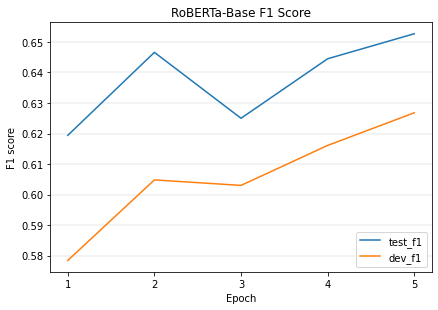

In [19]:
import matplotlib.pyplot as plt
import numpy as np

dev_f1 = [0.5784, 0.6048, 0.6030, 0.6161, 0.6268]
test_f1 = [0.6194, 0.6466, 0.6250, 0.6445, 0.6527]
epoch = np.arange(1,6,1)
plt.grid(axis = 'y', linewidth = 0.3)
plt.plot(epoch, test_f1, label='test_f1')
plt.plot(epoch, dev_f1, label='dev_f1')

plt.xticks(epoch)
plt.tight_layout()
plt.legend(loc='lower right')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.title('RoBERTa-Base F1 Score')

plt.savefig('RoBERTa-Base.jpg', dpi=300, bbox_inches='tight')


In [ ]:
from config import *
from CRFmodel import CRFModel
import itertools

# 창현 버전
# works
def train_epoch(model, optimizer, data, epoch_num=0, max_step=-1):

    loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1)
    dataloader = DataLoader(data, batch_size=CONFIG['batch_size'], sampler=RandomSampler(data), num_workers=0)

    for batch in dataloader:
        for i in range(len(batch)):
            if i == 0:
                sentences = batch[i].to(model.device())
                continue
            elif i==1:
                speaker_ids = batch[i].to(model.device())
                continue
            elif i==2:
                emotion_idxs = batch[i].to(model.device())
                continue
            elif i==3:
                mask = batch[i].to(model.device())
                continue
            elif i==4:
                last_turns = batch[i].to(model.device())
                continue
        loss = model(sentences, mask, speaker_ids, last_turns, emotion_idxs)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# not yet tested
def test(model, data):

    yPred = []
    yTrue = []
    model.eval()
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, batch_size=CONFIG['batch_size'], sampler=sampler, num_workers=0)
#    tq_test = tqdm(total=len(dataloader), desc="testing", position=2)
    # for batch_id, batch_data in enumerate(dataloader):
    #     batch_data = [x.to(model.device()) for x in batch_data]
    #     sentences = batch_data[0]
    #     speaker_ids = batch_data[1]
    #     emotion_idxs = batch_data[2].cpu().numpy().tolist()
    #     mask = batch_data[3]
    #     last_turns = batch_data[4]
    #     outputs = model(sentences, mask, speaker_ids, last_turns, None)
    for batch in dataloader:
        for i in range(len(batch)):
            if i == 0:
                sentences = batch[i].to(model.device())
                continue
            elif i==1:
                speaker_ids = batch[i].to(model.device())
                continue
            elif i==2:
                emotion_idxs = batch[i].to(model.device())
                continue
            elif i==3:
                mask = batch[i].to(model.device())
                continue
            elif i==4:
                last_turns = batch[i].to(model.device())
                continue
        out = model(sentences, mask, speaker_ids, last_turns, None)

        maskBatch = torch.arange(0, mask.shape[0])
        maskSequence = torch.arange(0, mask.shape[1])
        
        for batch1, sequence1 in torch.cartesian_prod(maskBatch, maskSequence):
            # Only if not padded (aka. there is information) -> mask==1 (True), APPEND
            if bool(mask[batch1][sequence1]) != True: 
                continue
            else:
                # print("Output: ", outputs)
                # print("Batch: ", batch_idx)
                # print("Seq: ", seq_idx)
                yPred.append(out[batch1][sequence1])
                yTrue.append(emotion_idxs[batch1][sequence1])
#        tq_test.update()
    score = f1_score(y_pred=yPred, y_true=yTrue, average='weighted')
    model.train()
    return score

# too many indices for tensor of dimension 2

In [5]:
import numpy as np
np.arange(0,5)

array([0, 1, 2, 3, 4])

In [ ]:
def test(model, data):

    pred_list = []
    hidden_pred_list = []
    selection_list = []
    y_true_list = []
    model.eval()
    sampler = SequentialSampler(data)
    dataloader = DataLoader(
        data,
        batch_size=CONFIG['batch_size'],
        sampler=sampler,
        num_workers=0,  # multiprocessing.cpu_count()
    )
    tq_test = tqdm(total=len(dataloader), desc="testing", position=2)
    for batch_id, batch_data in enumerate(dataloader):
        batch_data = [x.to(model.device()) for x in batch_data]
        sentences = batch_data[0]
        speaker_ids = batch_data[1]
        emotion_idxs = batch_data[2].cpu().numpy().tolist()
        mask = batch_data[3]
        last_turns = batch_data[4]
        outputs = model(sentences, mask, speaker_ids, last_turns, None)
        for batch_idx in range(mask.shape[0]):
            for seq_idx in range(mask.shape[1]):
                if mask[batch_idx][seq_idx]:
                    print("Output: ", outputs)
                    print("Batch: ", batch_idx)
                    print("Seq: ", seq_idx)
                    pred_list.append(outputs[batch_idx][seq_idx])
                    y_true_list.append(emotion_idxs[batch_idx][seq_idx])
        tq_test.update()
    F1 = f1_score(y_true=y_true_list, y_pred=pred_list, average='weighted')
    model.train()
    return F1

In [ ]:
def train_epoch(model, optimizer, data, epoch_num=0, max_step=-1):

    loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1)
    sampler = RandomSampler(data)
    dataloader = DataLoader(
        data,
        batch_size=CONFIG['batch_size'],
        sampler=sampler,
        num_workers=0  # multiprocessing.cpu_count()
    )
    tq_train = tqdm(total=len(dataloader), position=1)
    accumulation_steps = CONFIG['accumulation_steps']

    for batch_id, batch_data in enumerate(dataloader):
        batch_data = [x.to(model.device()) for x in batch_data]
        sentences = batch_data[0]
        speaker_ids = batch_data[1]
        emotion_idxs = batch_data[2]
        mask = batch_data[3]
        last_turns = batch_data[4]
        outputs = model(sentences, mask, speaker_ids, last_turns, emotion_idxs)
        loss = outputs
        # loss += loss_func(outputs[3], sentiment_idxs)
        tq_train.set_description('loss is {:.2f}'.format(loss.item()))
        tq_train.update()
        loss = loss / accumulation_steps
        loss.backward()
        if batch_id % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            # torch.cuda.empty_cache()
    tq_train.close()

In [2]:
hi = 0
if hi:
    print(hi)